In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.random_search import random_optimize
from pyfos.hyperoptimizers.greed_optimize import greed_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
import cPickle

In [2]:
with open('./data/results_cv_mad.pckl', 'rb') as inp:
    mad = cPickle.load(inp)
with open('./data/results_cv_rand.pckl', 'rb') as inp:
    rand = cPickle.load(inp)    
with open('./data/results_cv_greed.pckl', 'rb') as inp:
    greed = cPickle.load(inp)
with open('./data/results_cv_hoag.pckl', 'rb') as inp:
    hoag = cPickle.load(inp)

#for i in xrange(5):
#    greed[i].history = [rand[i].history[0]]+ greed[i].history
#X_train, X_test = np.load('../../../data/W_X_Tr.npy'), np.load('../../../data/W_X_Test.npy')
#Y_train, Y_test = np.load('../../../data/W_Y_Tr.npy'), np.load('../../../data/W_Y_Test.npy')



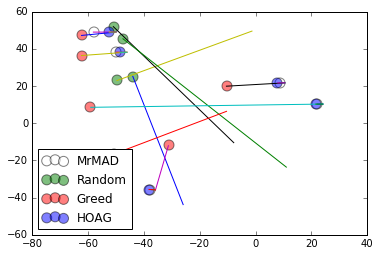

In [23]:
#plt.matshow(matrix.T)
for dataset, label, c in [(mad, 'MrMAD', 'w'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                        ]:
    first = True
    for i in dataset:
        first_value = i.history[0][0][0]
        i = i.best_values[0]
        
        first_value = np.log10(np.exp(2*first_value))*10
        i = np.log10(np.exp(2*i))*10
        if first:
            plt.scatter(i[0] + np.random.randn(1)*0.1,i[1]+ np.random.randn(1)*0.1, c=c, label=label, alpha=0.5, s=100)
            first = False
        else:
            plt.scatter(i[0]+ np.random.randn(1)*0.1,i[1]+ np.random.randn(1)*0.1, c=c, alpha=0.5, s=100)
        #print [first_value[0], i[0]],[first_value[1], i[1]]
        plt.plot([first_value[0], i[0]],[first_value[1], i[1]])
        
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (20,20)
#plt.scatter(2713%100 ,2713/100, s=1000)


DrMAD
DrMAD
DrMAD
DrMAD
DrMAD
DrMAD -3640.89376831
DrMAD -3474.19198608
Случайный поиск
Случайный поиск
Случайный поиск
Случайный поиск -3734.31756592
Случайный поиск -3305.1512146
Жадный алгоритм
Жадный алгоритм
Жадный алгоритм
Жадный алгоритм
Жадный алгоритм
Жадный алгоритм -3726.48751831
Жадный алгоритм -3416.79518738
HOAG
HOAG
HOAG
HOAG
HOAG
HOAG -3639.3616333
HOAG -3748.63866577


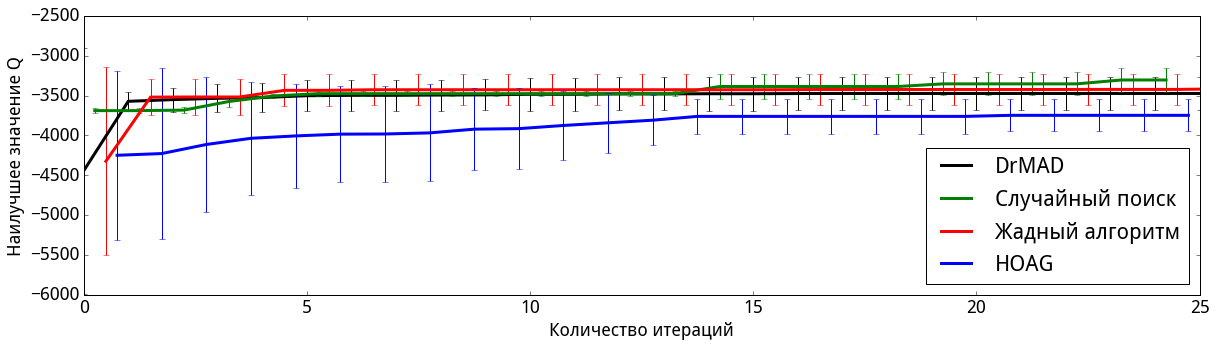

In [4]:
id = -1

font = {'family': 'Droid Sans',
        'weight': 'normal',
       'size':18}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (20, 5)
plt.xlabel(u'Количество итераций', fontsize=18)
plt.ylabel(u'Наилучшее значение Q', fontsize=18)


for dataset, label, c in [(mad, 'DrMAD', 'k'), 
                         (rand, u'Случайный поиск', 'g'),
                         (greed, u'Жадный алгоритм', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    
    line = []
    for b in dataset:
        print label
        
        history = []
        for i in xrange(0, len(b.history)):
        
            best_value = max([h[1] for h in b.history[:i+1]])
            
            history.append(best_value)
        line.append(history)
    print label, line[-1][0]
    print label,  np.mean(np.array(line)[:,-1])
    #print np.mean(line, axis=0)[-1]
    
    #plt.fill_between(range(len( np.mean(line, axis=0))),  np.mean(line, axis=0)-np.std(line, axis=0), np.mean(line, axis=0)+np.std(line, axis=0), facecolor=c, alpha=0.25 )
    plt.errorbar(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0), yerr=np.std(line, axis=0), c=c, lw=1)
    plt.plot(np.array(range(len(line[0])))+id*1.0/4, np.mean(line, axis=0),  c=c, lw=3, label=label)
    #plt.plot( np.mean(line, axis=0), label=label, c=c, lw=3)
#plt.ylim((-1000000, -1160000))
plt.xlim((0,25))
plt.legend(loc='best')


In [29]:
import theano.tensor as T
param_num = X_train.shape[1] * 10 + 10 + 10  + 1
accs = {}
Q = {}
lr = theano.shared(10**(-6))
hid = 10
alphas = theano.shared(np.array([1.0, 1.0]))
real_alphas = T.concatenate([T.repeat(alphas[0],  X_train.shape[1] * hid + hid)   , T.repeat(alphas[1],  hid + 1) ])

optimizer = partial(gd_optimizer, learning_rate=lr)
inits = [np.sqrt(2.0/(X_train.shape[1])).astype(theano.config.floatX), np.sqrt(2.0/(10)).astype(theano.config.floatX)]

model_build = partial(build_feedforward,  structure = [X_train.shape[1],10, 1],
                      init_sigmas=inits, nonlinearity=lambda x:T.nnet.relu(x), log_alphas =real_alphas, 
                      bias=True)


training_procedure = cv_tc( model_build, optimizer, X_train, Y_train, k = 4,  batch_size=25 )



X_t = T.matrix()

predicts = []

for m in training_procedure.models:    
    predict = m.predict_var(X_t)
    predicts.append(theano.function([X_t], predict))
print 'start'
id = -1
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []
    Q[label] = []
    accs[label] = []

    for b in dataset[::-1]:
        print 'start'
        
        Q[label].append([])
        accs[label].append([])
        history = []
        if len(b.history)==50:
            b.history = b.history+[b.history[-1]]
        
        for i in xrange(0, len(b.history), 10):
            
            best_value = np.argmax([h[1] for h in b.history[:i+1]])
            #print best_value
            best_value = b.history[best_value][0]
            #best_value = [np.array([6.0]*param_num)]
            
            # if i==len(b.history)-1:
            #     print best_value[0]
            for m in training_procedure.models:
                m.respawn()

            alphas.set_value(best_value[0])
            for _ in xrange(5000):
                training_procedure.do_train()
            #alphas.set_value(np.array([1.0, 1.0]))
         


            score = training_procedure.do_validation()
            res = []
            res = np.sqrt(np.mean((predicts[0](X_test)[:,0]-Y_test)**2))
            res2 = np.sqrt(np.mean((predicts[0](X_train)[:,0]-Y_train)**2))
            
            accs[label][-1].append((res,res2))
            Q[label][-1].append(score)
            print i,res,res2,score

start
MrMAD
start
0 0.731865077652 0.704347090514 -1057933.18301
10 0.743382378287 0.715361586907 -1056908.96793
20 0.734103219997 0.708572277273 -1056341.32221
30 0.768668938378 0.73730939291 -1055369.49596
40 0.757646937673 0.728029114524 -1054040.25265
50 0.761717388836 0.732185970713 -1051988.63383
start
0 0.724334338332 0.54830725048 -1099242.14043
10 0.800567085341 0.562028546107 -1098997.57794
20 0.739710628537 0.564751101908 -1098719.3975
30 0.803183451065 0.593604121976 -1098437.64587
40 0.75800526524 0.578899960314 -1098187.84603
50 0.789448055508 0.579892198383 -1097916.92192
start
0 0.727888001745 0.694449703628 -1060596.06225
10 0.729495670712 0.696846574897 -1060355.46387
20 0.718074761605 0.683644775346 -1059941.67584
30 0.728369909441 0.703163092157 -1059244.28066
40 0.737905212899 0.710110964087 -1058509.73003
50 0.744499660765 0.713049524123 -1057960.19646
start
0 0.869056056135 0.822875007292 -1068231.50002
10 0.889635157263 0.842934133098 -1068002.45517
20 0.9006453

In [5]:
with open('cv_results.pckl','wb') as out:
    cPickle.dump((Q,accs), out)

NameError: name 'Q' is not defined

In [5]:
with open('cv_results.pckl','rb') as inp:
    Q,accs= cPickle.load(inp)

    id = -1
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    k = label
    id+=1 
    mean, std = np.mean(Q[k], axis=0), np.std(Q[k], axis=0)
    plt.errorbar(np.array(range(len(mean)))+id*1.0/4, mean, yerr=std, c=c, lw=1, label=label)
    

IOError: [Errno 2] No such file or directory: 'cv_results.pckl'

MrMAD
[ 0.7602325   0.78851741  0.76857526  0.7923588   0.78107863  0.79121609]
Random
[ 0.75888904  0.85740147  0.74337975  0.73729728  0.74665926  0.7372302 ]
Greed
[ 0.79524756  0.78808111  0.77770072  0.77706186  0.77380345  0.77323295]
HOAG
[ 0.80515213  0.78470034  0.79263026  0.77548088  0.78240006  0.79407697]


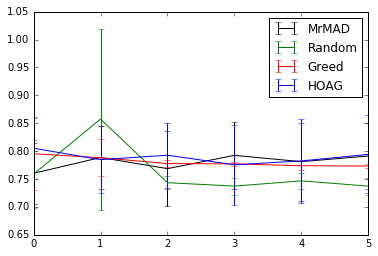

In [14]:
with open('var_results.pckl','rb') as inp:
    Q,accs= cPickle.load(inp)

    id = -1
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    k = label
    id+=1
    
    accs[k] = [[a[0]  for a in accsk ]   for accsk in accs[k]]
    
    #print accs[k]
    mean, std = np.mean(accs[k], axis=0), np.std(accs[k], axis=0)
    
    if len(mean)==5:
        #print label
        mean = mean.tolist()+[mean[4]]
        std = std.tolist()+[std[4]]
    print label
    print mean
    
    plt.errorbar(np.array(range(len(mean)))+id*0.0/4, mean, yerr=std, c=c, lw=1, label=label)
plt.legend(loc='best')

In [ ]:
batch_size = 25
lr = theano.shared(10**(-5))
log_alphas = theano.shared(np.array([10.0]))

optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward,  structure = [X_train.shape[1], 50,   1],  init_sigmas=[0.001]*3,  nonlinearity=lambda x:T.nnet.relu(x), log_alphas=log_alphas, bias=True)
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,   batch_size=batch_size )
model = model_build(params=training_procedure.models[0].params, dataset_size=1)
X = T.matrix()
predict = theano.function([X], model.predict_var(X))

def mse(Y1, Y2):
    return np.sum((Y1 - Y2)**2)

#100 epochs, 2500/25 ~ 100 iterations
err = []
Y = predict(X_test)
err.append(mse(Y[:,0], Y_test))
for epoch in xrange(100):
    
    for i in xrange(100):
        training_procedure.do_train()
    
    Y = predict(X_test)
    err.append(mse(Y[:,0], Y_test))
    

    

In [ ]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        history = []
        for i in xrange(len(b.history)):

            best_value = np.max([h[1] for h in b.history[:i+1]])
            history.append(best_value)
        history = np.array(history)
        history = history[-1]/history
        history = np.where(history>=0.99)[0]
       
        line.append(np.min(history))
        

        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """
    print np.mean(line), np.median(line), np.std(line)

In [ ]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    history = []
    for b in dataset:
        best_value = np.max([h[1] for h in b.history])
        history.append(best_value)
    print label, np.mean(history), np.std(history)

In [ ]:
dataset = hoag
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )

for d in dataset:
    X_, Y_ = [], []
    for h in d.history:
        alphas.set_value(h[0][0])
        for _ in xrange(10):
              training_procedure.do_train()
        X_.append(np.linalg.norm(training_procedure.models[0].params.eval() - np.array([20, 100])))
        Y_.append(np.linalg.norm(np.exp(h[0][0]- np.array([2713%100, 2713/100]))))
    plt.scatter(np.log(X_),np.log(Y_))
    plt.plot(np.log(X_),np.log(Y_))

In [ ]:
dataset = hoag
import theano.tensor as T
lr = theano.shared(0.01)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward, structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
training_procedure = simple_tc( model_build, optimizer, X_train, Y_train,  batch_size=100 )

for d in dataset:
    X_, Y_ = [], []
    for h in d.history:
        alphas.set_value(h[0][0])
        for _ in xrange(10):
              training_procedure.do_train()
        X_.append(np.linalg.norm(training_procedure.models[0].params.eval() - np.array([20, 100])))
        Y_.append(h[-1])
    plt.scatter(np.log(X_),np.log(-np.array(Y_)))
    plt.plot(np.log(X_),np.log(-np.array(Y_)))

In [6]:
for dataset, label, c in [(mad, 'MrMAD', 'k'), 
                         (rand, 'Random', 'g'),
                         (greed, 'Greed', 'r'),
                         (hoag, 'HOAG', 'b')
                          ]:
    id+=1
    print label
    line = []

    for b in dataset:

        
        #for i in xrange(len(b.history)):

        best_value = np.argmax([h[1] for h in b.history])
        line.append(best_value)
        
        #history = np.array(history)
        
        #history = history[-1]/history
        
        #history = [history[i-1]/history[i] for i in range(1, len(history))]# history#np.where(history>=0.99)[0]
        
        #history = np.where(history>=0.99)[0]
        #line.append(np.min(history))
        

        """
        bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
         [alpha_ranges, lr_ranges], verbose=100))
        X = T.matrix()    
        model = model_build(dataset_size=100)


        """
        
    print np.mean(line), np.median(line), np.std(line)

MrMAD
13.6 14.0 2.87054001888
Random
13.3333333333 14.0 8.17856276426
Greed
13.8 16.0 9.30376267969
HOAG
8.6 11.0 7.39188744503
